In [1]:
# Install yfinance if not already installed
try:
    import yfinance as yf
except ModuleNotFoundError:
    !pip install yfinance
    import yfinance as yf

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np

# List of 10+ stock tickers (you can modify this list as needed)
stocks = ['GS', 'BAC', 'C', 'WFC', 'AXP', 'MA', 'V', 'PYPL', 'BLK', 'SCHW']
market_index = '^GSPC'  # S&P 500

# Define time period (5 years)
start_date = "2019-01-01"
end_date = "2024-01-01"

# Download stock data (Close prices only)
stock_data = yf.download(stocks, start=start_date, end=end_date)['Close']
market_data = yf.download(market_index, start=start_date, end=end_date)['Close']

# Ensure 'Adj Close' exists before selecting
if 'Adj Close' in stock_data.columns:
    stock_data = stock_data['Adj Close']
if 'Adj Close' in market_data.columns:
    market_data = market_data['Adj Close']

# Convert to DataFrame if it's a Series
if isinstance(stock_data, pd.Series):
    stock_data = stock_data.to_frame()
if isinstance(market_data, pd.Series):
    market_data = market_data.to_frame()

# Ensure all tickers are present
if isinstance(stock_data, pd.DataFrame):
    stock_data = stock_data.dropna(axis=1, how='all')  # Drop stocks with all missing values

# Compute daily returns
daily_returns = stock_data.pct_change().dropna()
market_returns = market_data.pct_change().dropna()

# Save to CSV for further analysis
daily_returns.to_csv('daily_returns_close.csv')
market_returns.to_csv('market_returns_close.csv')

# Display first few rows of daily returns
daily_returns.head()


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


Ticker,AXP,BAC,BLK,C,GS,MA,PYPL,SCHW,V,WFC
Date,,,,,,,,,,
2019-01-03,-0.019520,-0.016026,-0.029377,-0.018121,-0.014649,-0.045115,-0.042682,-0.020683,-0.036037,-0.007882
2019-01-04,0.045061,0.041531,0.036616,0.048897,0.032683,0.047356,0.050920,0.042240,0.043081,0.029633
2019-01-07,0.005428,-0.000782,0.002782,0.008707,0.005541,0.007694,0.007650,0.007069,0.018032,-0.006465
2019-01-08,0.004889,-0.001956,0.012726,-0.002698,-0.003693,0.007282,0.020361,0.012634,0.005439,-0.002099
2019-01-09,0.001824,0.009800,0.005730,0.016589,0.006273,0.018151,0.009583,0.012708,0.011769,0.005469


In [3]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

# Load the daily returns data (Close prices only)
daily_returns = pd.read_csv('daily_returns_close.csv', index_col=0, parse_dates=True)
market_returns = pd.read_csv('market_returns_close.csv', index_col=0, parse_dates=True)

# Convert all columns to numeric, coercing errors to NaN
daily_returns = daily_returns.apply(pd.to_numeric, errors='coerce')
market_returns = market_returns.apply(pd.to_numeric, errors='coerce')

# Drop rows with NaN values (if any)
daily_returns = daily_returns.dropna()
market_returns = market_returns.dropna()

# Set the risk-free rate
risk_free_rate = 0.02

# Prepare the data for regression
# Calculate excess returns for each asset and the market
excess_returns = daily_returns.sub(risk_free_rate / 252, axis=0)  # Assuming 252 trading days in a year
excess_market_returns = market_returns.sub(risk_free_rate / 252, axis=0)

# Initialize dictionaries to store regression results
alphas = {}
betas = {}
idiosyncratic_variances = {}

# Perform linear regression for each asset
for stock in daily_returns.columns:
    X = sm.add_constant(excess_market_returns)  # Add a constant to the model (for alpha)
    y = excess_returns[stock]
    
    model = sm.OLS(y, X).fit()
    alphas[stock] = model.params[0]
    betas[stock] = model.params[1]
    
    # Calculate idiosyncratic variance (variance of residuals)
    residuals = model.resid
    idiosyncratic_variances[stock] = np.var(residuals)

# Calculate expected returns using CAPM
average_market_return = np.mean(excess_market_returns)
expected_returns = {stock: risk_free_rate + betas[stock] * (average_market_return - risk_free_rate) for stock in daily_returns.columns}

# Create a DataFrame to store the results
results_df = pd.DataFrame({
    'Stock': daily_returns.columns,
    'Alpha': [alphas[stock] for stock in daily_returns.columns],
    'Beta': [betas[stock] for stock in daily_returns.columns],
    'Expected Return': [expected_returns[stock] for stock in daily_returns.columns],
    'Idiosyncratic Variance': [idiosyncratic_variances[stock] for stock in daily_returns.columns]
})

# Save the results to a CSV file
results_df.to_csv('linear_regression_results.csv', index=False)

# Print the results
print("Linear Regression Results:")
print(results_df)

Linear Regression Results:
  Stock     Alpha      Beta  Expected Return  Idiosyncratic Variance
0   AXP  0.000107  1.309565        -0.005507                0.000257
1   BAC -0.000129  1.222406        -0.003810                0.000239
2   BLK  0.000168  1.229459        -0.003947                0.000129
3     C -0.000354  1.320078        -0.005712                0.000286
4    GS  0.000271  1.148924        -0.002379                0.000188
5    MA  0.000168  1.181714        -0.003017                0.000145
6  PYPL -0.000667  1.350012        -0.006295                0.000428
7  SCHW  0.000108  1.103587        -0.001496                0.000392
8     V  0.000091  1.048805        -0.000428                0.000113
9   WFC -0.000265  1.200052        -0.003374                0.000312


C:\Users\mg24324\AppData\Local\Temp\ipykernel_13440\1090668909.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alphas[stock] = model.params[0]
C:\Users\mg24324\AppData\Local\Temp\ipykernel_13440\1090668909.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  betas[stock] = model.params[1]
C:\Users\mg24324\AppData\Local\Temp\ipykernel_13440\1090668909.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alphas[stock] = model.par

In [4]:
!pip install cvxopt

Defaulting to user installation because normal site-packages is not writeable


In [7]:
import pandas as pd
import numpy as np
from cvxopt import matrix, solvers

# Load the results from Task 2
results_df = pd.read_csv('linear_regression_results.csv')

# Extract expected returns, betas, and idiosyncratic variances
expected_returns = results_df['Expected Return'].values
betas = results_df['Beta'].values
idiosyncratic_variances = results_df['Idiosyncratic Variance'].values

# Market variance (variance of market returns)
market_returns = pd.read_csv('market_returns_close.csv', index_col=0, parse_dates=True)
market_variance = np.var(market_returns.values)  # Use .values to avoid DataFrame warning

# Number of assets
n_assets = len(expected_returns)

# Construct the covariance matrix
cov_matrix = np.zeros((n_assets, n_assets))

# Systematic risk component
for i in range(n_assets):
    for j in range(n_assets):
        if i == j:
            # Diagonal elements: systematic risk + idiosyncratic risk
            cov_matrix[i, j] = (betas[i] * betas[j] * market_variance) + idiosyncratic_variances[i]
        else:
            # Off-diagonal elements: systematic risk only
            cov_matrix[i, j] = betas[i] * betas[j] * market_variance

# Define the QP problem
# Objective: Minimize (1/2) * w^T * cov_matrix * w
P = matrix(cov_matrix)  # Covariance matrix
q = matrix(np.zeros(n_assets))  # Linear term (zero for minimization)

# Constraints:
# 1. Sum of weights = 1
# 2. Portfolio return = target return
# 3. Weights >= 0 (no short selling)

# Define the equality constraints (sum of weights = 1, portfolio return = target return)
# Ensure matrix A has the correct shape: (2, n_assets)
A = np.vstack((np.ones(n_assets), expected_returns))  # Stack constraints
A = matrix(A)  # Convert to CVXPY matrix type
b = matrix([1.0, 0.05])  # Sum of weights = 1, target return = 5% (you can change this)

# Define the inequality constraints (weights >= 0)
G = matrix(-np.eye(n_assets))  # Negative identity matrix for non-negativity
h = matrix(np.zeros(n_assets))  # Zero vector for non-negativity

# Solve the QP problem
sol = solvers.qp(P, q, G, h, A, b)

# Extract the optimal weights
optimal_weights = np.array(sol['x']).flatten()

# Save the optimal weights to a CSV file
weights_df = pd.DataFrame({
    'Stock': results_df['Stock'],
    'Optimal Weight': optimal_weights
})
weights_df.to_csv('optimal_portfolio_weights.csv', index=False)

# Print the results
print("Optimal Portfolio Weights:")
print(weights_df)


     pcost       dcost       gap    pres   dres
 0:  1.2201e-02  8.3740e+01  3e+02  2e+01  2e+01
 1:  1.6876e-02  1.6727e+02  4e+01  6e+00  7e+00
 2:  1.6648e-02  1.0453e+03  3e+01  5e+00  6e+00
 3:  1.6567e-02  3.1857e+04  2e+02  5e+00  6e+00
 4:  1.6548e-02  6.5929e+06  1e+03  5e+00  6e+00
 5:  1.6547e-02  3.0580e+10  9e+04  5e+00  6e+00
 6:  8.8668e-02  2.3763e+17  2e+16  2e+01  9e+00
 7:  1.4944e-01  2.4434e+17  2e+16  3e+01  4e+03
 8:  1.2653e-01  2.8752e+18  3e+16  3e+01  4e+03
 9:  1.2585e-01  9.2675e+19  6e+17  3e+01  6e+03
10:  1.2433e-01  1.2570e+22  1e+19  3e+01  7e+05
11:  1.2412e-01  1.5130e+25  2e+20  3e+01  9e+08
12:  1.2411e-01  8.5632e+29  1e+23  3e+01  3e+13
Terminated (singular KKT matrix).
Optimal Portfolio Weights:
  Stock  Optimal Weight
0   AXP       -1.122581
1   BAC       -1.122581
2   BLK       -1.122581
3     C       -1.122581
4    GS       -1.122581
5    MA       -1.122581
6  PYPL       -1.122581
7  SCHW       -1.122581
8     V      -19.926837
9   WFC       

     pcost       dcost       gap    pres   dres
 0:  2.1404e-04 -9.9974e-01  2e+01  4e+00  4e+00
 1:  2.2330e-04 -5.7889e-01  2e+00  3e-01  4e-01
 2:  2.6958e-04 -5.4493e-03  3e-01  7e-02  8e-02
 3:  3.7691e-04 -2.1654e-03  1e-02  2e-03  3e-03
 4:  3.7842e-04  3.5300e-04  1e-04  2e-05  3e-05
 5:  3.7844e-04  3.7818e-04  1e-06  2e-07  3e-07
 6:  3.7844e-04  3.7843e-04  1e-08  2e-09  3e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  1.9137e-04 -1.0416e+00  1e+01  3e+00  4e+00
 1:  1.9568e-04 -7.2177e-01  1e+00  2e-01  2e-01
 2:  2.1094e-04 -1.7634e-01  2e-01  3e-02  3e-02
 3:  2.2429e-04 -1.4990e-02  2e-02  4e-14  1e-15
 4:  2.2379e-04 -2.9707e-05  3e-04  1e-15  8e-17
 5:  2.0889e-04  1.7138e-04  4e-05  2e-17  9e-18
 6:  2.0182e-04  1.9655e-04  5e-06  3e-16  4e-19
 7:  2.0079e-04  1.9953e-04  1e-06  1e-16  2e-19
 8:  2.0010e-04  1.9998e-04  1e-07  1e-16  2e-19
 9:  2.0004e-04  2.0004e-04  2e-09  6e-17  2e-19
Optimal solution found.
     pcost       dcost 

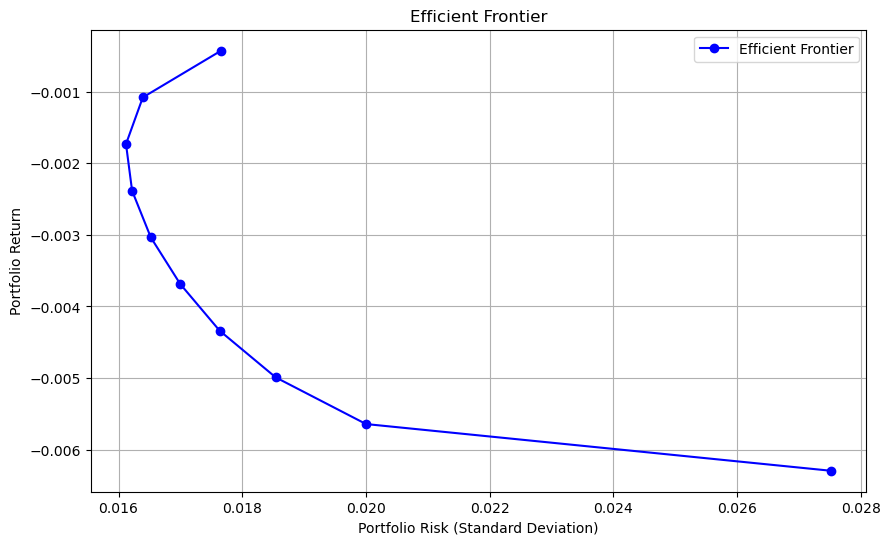

In [6]:
import pandas as pd
import numpy as np
from cvxopt import matrix, solvers
import matplotlib.pyplot as plt

# Load the results from Task 2
results_df = pd.read_csv('linear_regression_results.csv')

# Extract expected returns, betas, and idiosyncratic variances
expected_returns = results_df['Expected Return'].values
betas = results_df['Beta'].values
idiosyncratic_variances = results_df['Idiosyncratic Variance'].values

# Market variance (variance of market returns)
market_returns = pd.read_csv('market_returns_close.csv', index_col=0, parse_dates=True)
market_variance = np.var(market_returns.values)  # Use .values to avoid DataFrame warning

# Number of assets
n_assets = len(expected_returns)

# Construct the covariance matrix
cov_matrix = np.zeros((n_assets, n_assets))

# Systematic risk component
for i in range(n_assets):
    for j in range(n_assets):
        if i == j:
            # Diagonal elements: systematic risk + idiosyncratic risk
            cov_matrix[i, j] = (betas[i] * betas[j] * market_variance) + idiosyncratic_variances[i]
        else:
            # Off-diagonal elements: systematic risk only
            cov_matrix[i, j] = betas[i] * betas[j] * market_variance

# Define the QP problem
# Objective: Minimize (1/2) * w^T * cov_matrix * w
P = matrix(cov_matrix)  # Covariance matrix
q = matrix(np.zeros(n_assets))  # Linear term (zero for minimization)

# Define the inequality constraints (weights >= 0)
G = matrix(-np.eye(n_assets))  # Negative identity matrix for non-negativity
h = matrix(np.zeros(n_assets))  # Zero vector for non-negativity

# Define a range of target returns
min_return = np.min(expected_returns)
max_return = np.max(expected_returns)
target_returns = np.linspace(min_return, max_return, 10)  # 10 equally spaced target returns

# Initialize lists to store portfolio risks and returns
portfolio_risks = []
portfolio_returns = []

# Solve the QP problem for each target return
for target_return in target_returns:
    # Define the equality constraints (sum of weights = 1, portfolio return = target return)
    # Ensure matrix A_eq has the correct shape: (2, n_assets)
    A_eq = np.vstack((np.ones(n_assets), expected_returns))  # Stack constraints
    A_eq = matrix(A_eq)  # Convert to CVXPY matrix type
    b_eq = matrix([1.0, target_return])  # Sum of weights = 1, target return

    # Solve the QP problem
    sol = solvers.qp(P, q, G, h, A_eq, b_eq)

    # Extract the optimal weights
    optimal_weights = np.array(sol['x']).flatten()

    # Calculate the portfolio risk (standard deviation)
    portfolio_risk = np.sqrt(np.dot(optimal_weights.T, np.dot(cov_matrix, optimal_weights)))

    # Store the results
    portfolio_risks.append(portfolio_risk)
    portfolio_returns.append(target_return)

# Plot the efficient frontier
plt.figure(figsize=(10, 6))
plt.plot(portfolio_risks, portfolio_returns, 'bo-', label='Efficient Frontier')
plt.xlabel('Portfolio Risk (Standard Deviation)')
plt.ylabel('Portfolio Return')
plt.title('Efficient Frontier')
plt.grid(True)
plt.legend()
plt.show()
